In [ ]:
!pip install -q transformers datasets evaluate scikit-learn seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 37.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import warnings

warnings.filterwarnings('ignore')

# Configuration
MODEL_NAME = "sagorsarker/bangla-bert-base"
FILE_PATH = "/kaggle/input/med-trust-clean/cleaned_data.xlsx" # Updated Path
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5

print("Libraries imported and configuration set.")

2025-11-28 18:04:27.588224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764353067.775946      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764353067.828788      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Libraries imported and configuration set.


In [ ]:
import os
import pandas as pd

# 1. Automatically find the file in the input directory
found_file_path = None
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Look for the file, ignoring hidden files
        if 'cleaned_data' in filename:
            found_file_path = os.path.join(dirname, filename)
            break
    if found_file_path:
        break

if found_file_path is None:
    print("❌ Error: Could not find 'cleaned_data' file in /kaggle/input")
else:
    print(f"✅ Found file at: {found_file_path}")

    # 2. Load the file based on its extension
    try:
        if found_file_path.endswith('.csv'):
            df = pd.read_csv(found_file_path)
            print("loaded as CSV.")
        else:
            # Assume excel if not csv
            df = pd.read_excel(found_file_path)
            print("loaded as Excel.")

        # 3. Fix Columns and Labels
        if 'Lable' in df.columns:
            df.rename(columns={'Lable': 'Label'}, inplace=True)

        label_map = {'Not Relevant': 0, 'Partially Relevant': 1, 'Highly Relevant': 2}
        df['label'] = df['Label'].map(label_map)

        # 4. Success Check
        print("Data Shape:", df.shape)
        print(df.head())

    except Exception as e:
        print(f"❌ Failed to load file: {e}")

✅ Found file at: /kaggle/input/cleaned_data.xlsx
loaded as Excel.
Data Shape: (15384, 5)
  Symptoms Genre_cleaned                              Used Prompt_cleaned  \
0            গ্যাস্ট্রিক  খাবার খেলেই বুক জ্বালা করে , কীভাবে এড়ানো যায়   
1            গ্যাস্ট্রিক  খাবার খেলেই বুক জ্বালা করে , কীভাবে এড়ানো যায়   
2            গ্যাস্ট্রিক  খাবার খেলেই বুক জ্বালা করে , কীভাবে এড়ানো যায়   
3            গ্যাস্ট্রিক  খাবার খেলেই বুক জ্বালা করে , কীভাবে এড়ানো যায়   
4            গ্যাস্ট্রিক  খাবার খেলেই বুক জ্বালা করে , কীভাবে এড়ানো যায়   

                                    Response_cleaned            Label  label  
0  খাওয়ার পর বুকের মাঝখানে জ্বালাপোড়া অনুভূত হয...  Highly Relevant      2  
1  খাওয়ার পর যদি আপনার বুক জ্বালাপোড়া হয় , তাহ...  Highly Relevant      2  
2  ভাত বা মাংস খাওয়ার পর যদি আপনার বুক জ্বালাপোড...  Highly Relevant      2  
3  খাওয়ার পর বুক জ্বালাপোড়ার সাথে ঢেকুরও আসতে প...  Highly Relevant      2  
4  খাওয়ার পরপরই যদি আপনার বুক জ্বালাপোড়া হয় , ... 

In [ ]:
def plot_training_history(history, title):
    """Plots Loss and Accuracy (Train vs Validation)"""

    # Extract data from logs
    epochs = [x['epoch'] for x in history if 'epoch' in x]

    # 1. Loss extraction
    # 'loss' is the standard training step loss.
    # 'eval_validation_loss' or 'eval_loss' is validation loss.
    train_loss = [x['loss'] for x in history if 'loss' in x]
    val_loss = [x.get('eval_validation_loss', x.get('eval_loss')) for x in history if 'eval_loss' in x or 'eval_validation_loss' in x]

    # Align epochs for loss (training loss is logged more often than validation)
    train_loss_epochs = [x['epoch'] for x in history if 'loss' in x]
    val_epochs = [x['epoch'] for x in history if 'eval_loss' in x or 'eval_validation_loss' in x]

    # 2. Accuracy extraction
    # We look for 'eval_train_accuracy' (which we will generate) and 'eval_validation_accuracy'
    train_acc = [x.get('eval_train_accuracy') for x in history if 'eval_train_accuracy' in x]
    val_acc = [x.get('eval_validation_accuracy', x.get('eval_accuracy')) for x in history if 'eval_validation_accuracy' in x or 'eval_accuracy' in x]
    acc_epochs = [x['epoch'] for x in history if 'eval_train_accuracy' in x or 'eval_validation_accuracy' in x or 'eval_accuracy' in x]

    # --- PLOTTING ---
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss
    if train_loss:
        ax[0].plot(train_loss_epochs, train_loss, label='Training Loss', alpha=0.6)
    if val_loss:
        ax[0].plot(val_epochs, val_loss, label='Validation Loss', linewidth=2)
    ax[0].set_title(f'{title} - Loss Curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    # Plot Accuracy
    if train_acc:
        ax[1].plot(acc_epochs, train_acc, label='Training Accuracy', color='blue', marker='o')
    if val_acc:
        ax[1].plot(acc_epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')

    ax[1].set_title(f'{title} - Accuracy Curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

# Keep the other functions (plot_multiclass_roc, compute_metrics) as they were
def plot_multiclass_roc(y_test, y_score, n_classes, title):
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green']
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve ({class_names[i]}) (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [ ]:
# Approach 1: Combine All Columns
# Format: "Genre: [G] Prompt: [P] Response: [R]"
df['text_combined'] = (
    "Genre: " + df['Symptoms Genre_cleaned'] +
    " Prompt: " + df['Used Prompt_cleaned'] +
    " Response: " + df['Response_cleaned']
)

# Split Data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Convert to HF Dataset
dataset_1 = DatasetDict({
    'train': Dataset.from_pandas(train_df[['text_combined', 'label']].rename(columns={'text_combined': 'text'})),
    'validation': Dataset.from_pandas(val_df[['text_combined', 'label']].rename(columns={'text_combined': 'text'})),
    'test': Dataset.from_pandas(test_df[['text_combined', 'label']].rename(columns={'text_combined': 'text'}))
})

print("Dataset 1 prepared.")
print("Train size:", len(dataset_1['train']))
print("Test size:", len(dataset_1['test']))

Dataset 1 prepared.
Train size: 12307
Test size: 1539


In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=MAX_LEN)

tokenized_datasets_1 = dataset_1.map(tokenize_function, batched=True)

# Model
model_1 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# Training Arguments with Disk Management
args_1 = TrainingArguments(
    output_dir="bert_output_appr_1",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="validation_accuracy",
    logging_dir='./logs/appr_1',
    logging_steps=50,
    report_to="none",
    save_total_limit=1,        # <--- FIX: Keep only 1 checkpoint
    overwrite_output_dir=True  # <--- FIX: Overwrite previous runs
)

# Eval on both Train and Validation
eval_datasets = {
    "train": tokenized_datasets_1['train'],
    "validation": tokenized_datasets_1['validation']
}

trainer_1 = Trainer(
    model=model_1,
    args=args_1,
    train_dataset=tokenized_datasets_1['train'],
    eval_dataset=eval_datasets,
    compute_metrics=compute_metrics,
)

print("Trainer 1 initialized (Disk Safe Mode).")

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/12307 [00:00<?, ? examples/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/1538 [00:00<?, ? examples/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/1539 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer 1 initialized (Disk Safe Mode).


In [ ]:
print("Training Approach 1...")
trainer_1.train()

Training Approach 1...


Epoch,Training Loss,Validation Loss,Train Loss,Train Accuracy,Train F1,Train Precision,Train Recall,Validation Accuracy,Validation F1,Validation Precision,Validation Recall
1,0.585800,0.608374,0.492267,0.791013,0.793943,0.823909,0.791013,0.721066,0.725477,0.757365,0.721066
2,0.442500,0.522402,0.277033,0.896888,0.895342,0.898267,0.896888,0.787386,0.781479,0.789418,0.787386
3,0.278700,0.494462,0.129988,0.952954,0.953308,0.955184,0.952954,0.806242,0.808695,0.819084,0.806242
4,0.216300,0.558047,0.065449,0.977086,0.977068,0.977374,0.977086,0.827048,0.826706,0.827991,0.827048
5,0.114500,0.740074,0.033069,0.989681,0.989699,0.989806,0.989681,0.832250,0.833848,0.840871,0.832250
6,0.077100,0.885723,0.022295,0.993987,0.993984,0.993988,0.993987,0.839402,0.838722,0.838508,0.839402
7,0.031700,0.949983,0.013284,0.996506,0.996505,0.996517,0.996506,0.847854,0.847157,0.847142,0.847854
8,0.049400,0.984523,0.006044,0.997969,0.997968,0.997972,0.997969,0.859558,0.859801,0.860852,0.859558
9,0.017700,0.975588,0.003838,0.998375,0.998375,0.998376,0.998375,0.864759,0.864701,0.864746,0.864759
10,0.007500,0.984639,0.003502,0.998375,0.998375,0.998375,0.998375,0.863459,0.863631,0.863998,0.863459


TrainOutput(global_step=7700, training_loss=0.20391359173342005, metrics={'train_runtime': 2211.0394, 'train_samples_per_second': 55.662, 'train_steps_per_second': 3.483, 'total_flos': 8095342079946240.0, 'train_loss': 0.20391359173342005, 'epoch': 10.0})

In [ ]:
def plot_training_history(history, title):
    """Plots Loss and Accuracy (Train vs Validation) - Fixed Version"""

    # --- 1. LOSS Extraction ---
    # Training Loss (logged every 50 steps)
    train_loss_data = [(x['epoch'], x['loss']) for x in history if 'loss' in x]
    train_loss_x = [item[0] for item in train_loss_data]
    train_loss_y = [item[1] for item in train_loss_data]

    # Validation Loss (logged at end of epoch)
    # Checks for 'eval_validation_loss' (if dict) or 'eval_loss' (standard)
    val_loss_data = [(x['epoch'], x.get('eval_validation_loss', x.get('eval_loss')))
                     for x in history
                     if 'eval_loss' in x or 'eval_validation_loss' in x]
    val_loss_x = [item[0] for item in val_loss_data]
    val_loss_y = [item[1] for item in val_loss_data]

    # --- 2. ACCURACY Extraction ---
    # Training Accuracy (logged at end of epoch)
    train_acc_data = [(x['epoch'], x['eval_train_accuracy'])
                      for x in history if 'eval_train_accuracy' in x]
    train_acc_x = [item[0] for item in train_acc_data]
    train_acc_y = [item[1] for item in train_acc_data]

    # Validation Accuracy (logged at end of epoch)
    # Checks for 'eval_validation_accuracy' or 'eval_accuracy'
    # We filter out 'eval_train_accuracy' to ensure we don't accidentally grab the wrong line
    val_acc_data = [(x['epoch'], x.get('eval_validation_accuracy', x.get('eval_accuracy')))
                    for x in history
                    if ('eval_validation_accuracy' in x or 'eval_accuracy' in x)
                    and 'eval_train_accuracy' not in x]
    val_acc_x = [item[0] for item in val_acc_data]
    val_acc_y = [item[1] for item in val_acc_data]

    # --- PLOTTING ---
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss
    if train_loss_x:
        ax[0].plot(train_loss_x, train_loss_y, label='Training Loss', alpha=0.6)
    if val_loss_x:
        ax[0].plot(val_loss_x, val_loss_y, label='Validation Loss', linewidth=2)
    ax[0].set_title(f'{title} - Loss Curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    # Plot Accuracy
    if train_acc_x:
        ax[1].plot(train_acc_x, train_acc_y, label='Training Accuracy', color='blue', marker='o')
    if val_acc_x:
        ax[1].plot(val_acc_x, val_acc_y, label='Validation Accuracy', color='orange', marker='o')

    ax[1].set_title(f'{title} - Accuracy Curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

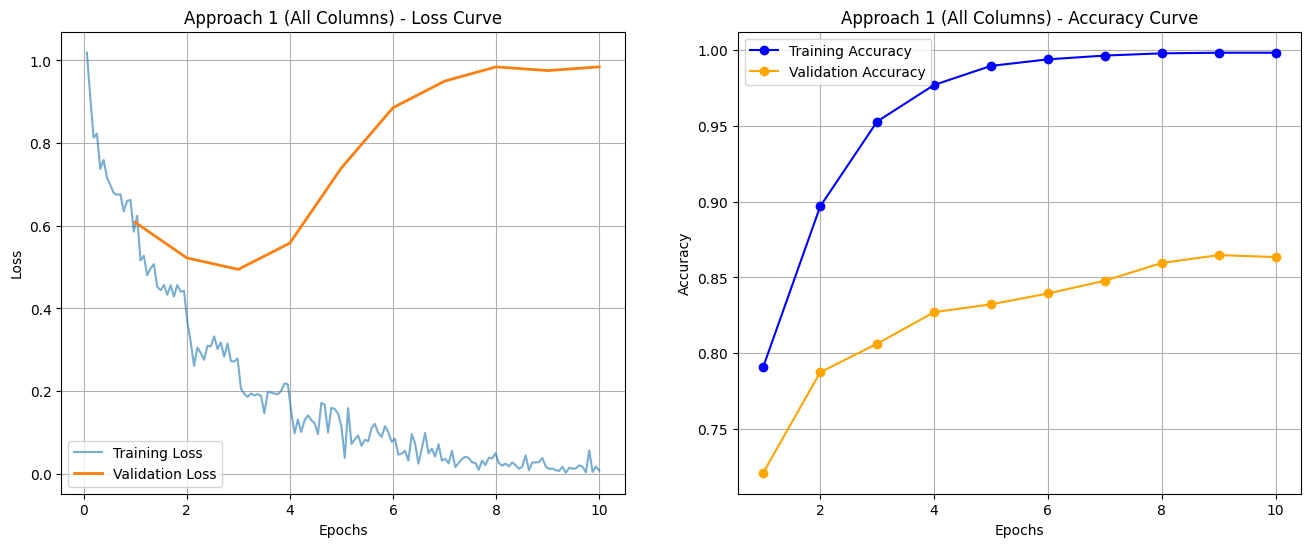

Evaluating on Test Set...



--- Classification Report (Approach 1) ---
                    precision    recall  f1-score   support

      Not Relevant     0.9137    0.8957    0.9046       508
Partially Relevant     0.8112    0.8189    0.8150       530
   Highly Relevant     0.8636    0.8723    0.8679       501

          accuracy                         0.8616      1539
         macro avg     0.8628    0.8623    0.8625      1539
      weighted avg     0.8621    0.8616    0.8618      1539



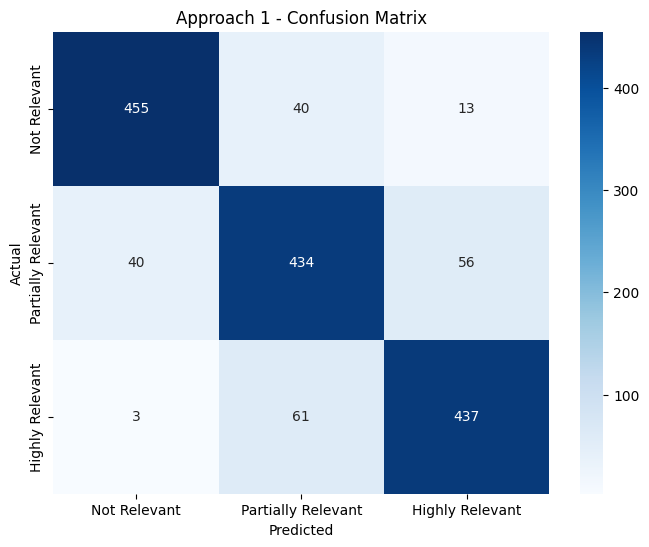

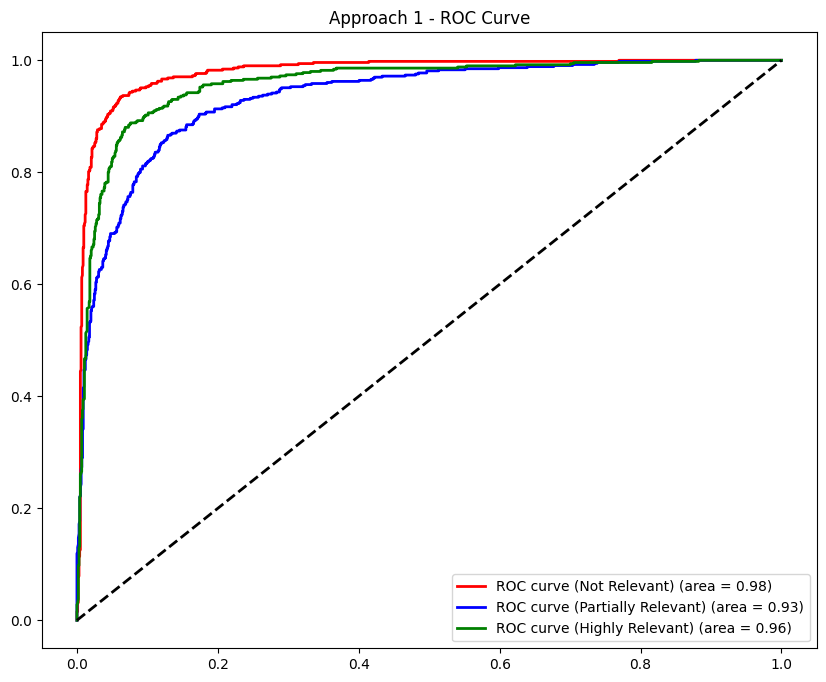

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# 1. Define class names (fixes the NameError)
class_names = ['Not Relevant', 'Partially Relevant', 'Highly Relevant']

# 2. Plot Curves (Loss & Accuracy)
# Ensure you have run the updated plot_training_history function from the previous step!
plot_training_history(trainer_1.state.log_history, "Approach 1 (All Columns)")

# 3. Predict on Test Set
print("Evaluating on Test Set...")
preds_output = trainer_1.predict(tokenized_datasets_1['test'])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=-1).numpy()
y_true = preds_output.label_ids

# 4. Classification Report
print("\n--- Classification Report (Approach 1) ---")
print(classification_report(y_true, y_preds, target_names=class_names, digits=4))

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Approach 1 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 6. ROC Curve
plot_multiclass_roc(y_true, y_probs, n_classes=3, title="Approach 1")

In [ ]:
import shutil
import os

# Clean up Approach 1 Output to free space for Approach 2
dir_to_clean = "bert_output_appr_1"
if os.path.exists(dir_to_clean):
    shutil.rmtree(dir_to_clean)
    print(f"✅ Deleted {dir_to_clean} to save disk space.")

✅ Deleted bert_output_appr_1 to save disk space.


In [ ]:
# Approach 2: Response Only

# FIX: Add the new column directly to the split DataFrames
train_df['text_response'] = "Response: " + train_df['Response_cleaned']
val_df['text_response'] = "Response: " + val_df['Response_cleaned']
test_df['text_response'] = "Response: " + test_df['Response_cleaned']

# Convert to HF Dataset (using the same splits as before to be fair)
dataset_2 = DatasetDict({
    'train': Dataset.from_pandas(train_df[['text_response', 'label']].rename(columns={'text_response': 'text'})),
    'validation': Dataset.from_pandas(val_df[['text_response', 'label']].rename(columns={'text_response': 'text'})),
    'test': Dataset.from_pandas(test_df[['text_response', 'label']].rename(columns={'text_response': 'text'}))
})

print("Dataset 2 prepared.")

Dataset 2 prepared.


In [ ]:
# Tokenize
tokenized_datasets_2 = dataset_2.map(tokenize_function, batched=True)

# Model (Re-initialize to start fresh)
model_2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# Training Arguments
args_2 = TrainingArguments(
    output_dir="bert_output_appr_2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="validation_accuracy",
    logging_dir='./logs/appr_2',
    logging_steps=50,
    report_to="none",

    # --- DISK MANAGEMENT ---
    save_total_limit=1,       # Keep only 1 checkpoint
    overwrite_output_dir=True # Overwrite previous runs
)

# Eval on both Train and Validation (for accuracy curves)
eval_datasets_2 = {
    "train": tokenized_datasets_2['train'],
    "validation": tokenized_datasets_2['validation']
}

trainer_2 = Trainer(
    model=model_2,
    args=args_2,
    train_dataset=tokenized_datasets_2['train'],
    eval_dataset=eval_datasets_2, # <--- Passing Dict triggers evaluation on both
    compute_metrics=compute_metrics,
)

print("Trainer 2 initialized (Disk Safe Mode).")

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/12307 [00:00<?, ? examples/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/1538 [00:00<?, ? examples/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/1539 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer 2 initialized (Disk Safe Mode).


In [ ]:
print("Training Approach 2...")
trainer_2.train()

Training Approach 2...


Epoch,Training Loss,Validation Loss,Train Loss,Train Accuracy,Train F1,Train Precision,Train Recall,Validation Accuracy,Validation F1,Validation Precision,Validation Recall
1,0.608600,0.627155,0.511086,0.784107,0.787897,0.816451,0.784107,0.719766,0.723016,0.754534,0.719766
2,0.452100,0.534113,0.277905,0.899082,0.897878,0.899963,0.899082,0.779584,0.775484,0.779502,0.779584
3,0.334700,0.542903,0.128054,0.958316,0.958547,0.959554,0.958316,0.804291,0.806174,0.811191,0.804291
4,0.218700,0.611006,0.049718,0.985699,0.985690,0.985698,0.985699,0.821847,0.821607,0.821460,0.821847
5,0.124900,0.886333,0.029002,0.991550,0.991551,0.991577,0.991550,0.815995,0.817345,0.823526,0.815995
6,0.109100,0.993443,0.015976,0.996181,0.996181,0.996181,0.996181,0.832250,0.832378,0.833042,0.832250
7,0.040200,1.169677,0.010854,0.997481,0.997482,0.997483,0.997481,0.830299,0.830987,0.832492,0.830299
8,0.036000,1.158779,0.008960,0.997725,0.997724,0.997726,0.997725,0.840052,0.839294,0.839200,0.840052
9,0.024800,1.182846,0.005645,0.998212,0.998213,0.998215,0.998212,0.838752,0.839339,0.840456,0.838752
10,0.021600,1.195639,0.005523,0.998212,0.998213,0.998213,0.998212,0.842653,0.843100,0.843934,0.842653


TrainOutput(global_step=7700, training_loss=0.2087069809281981, metrics={'train_runtime': 2213.9697, 'train_samples_per_second': 55.588, 'train_steps_per_second': 3.478, 'total_flos': 8095342079946240.0, 'train_loss': 0.2087069809281981, 'epoch': 10.0})

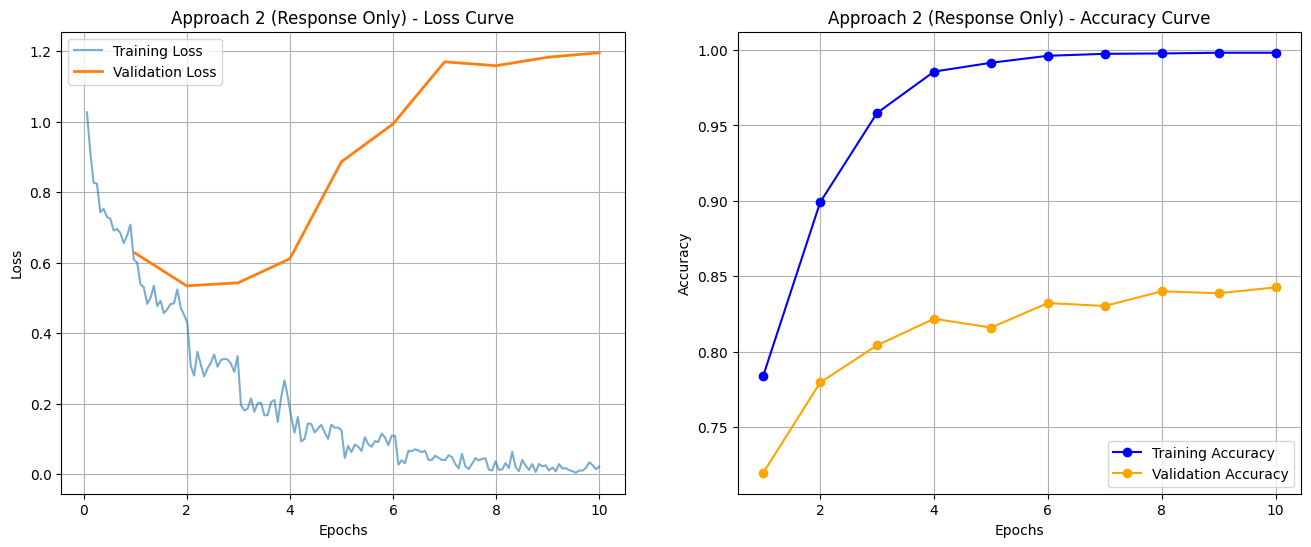

Evaluating on Test Set...



--- Classification Report (Approach 2) ---
                    precision    recall  f1-score   support

      Not Relevant     0.9144    0.8622    0.8875       508
Partially Relevant     0.7667    0.8245    0.7945       530
   Highly Relevant     0.8490    0.8303    0.8396       501

          accuracy                         0.8389      1539
         macro avg     0.8434    0.8390    0.8405      1539
      weighted avg     0.8422    0.8389    0.8399      1539



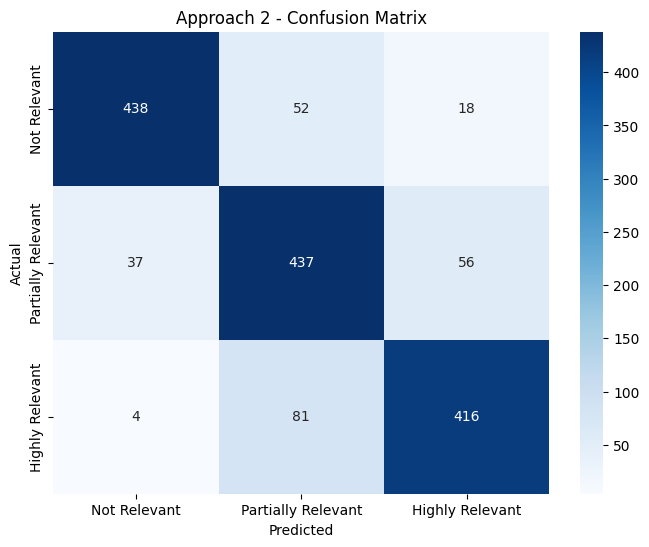

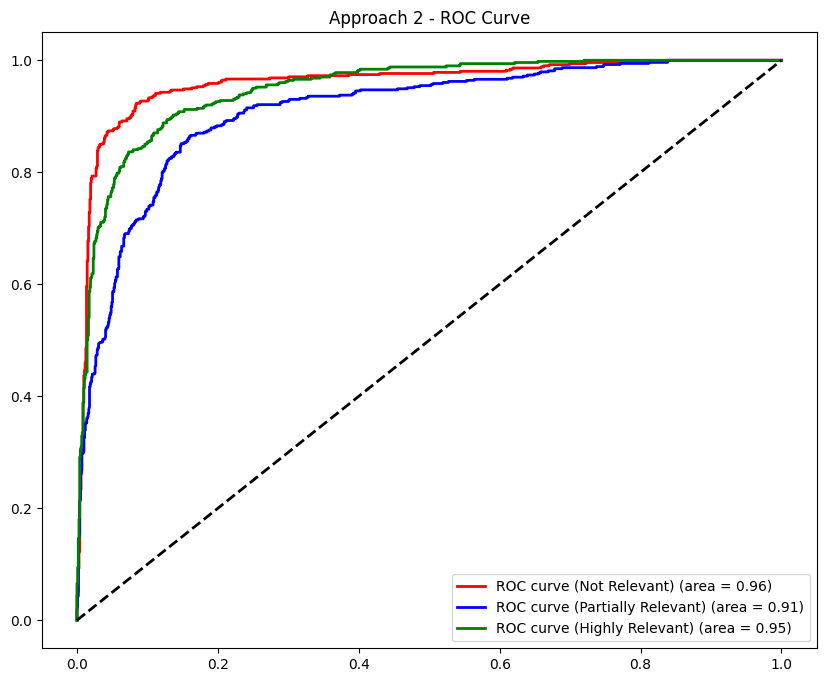

In [ ]:
# 1. Plot Curves (Loss & Accuracy)
plot_training_history(trainer_2.state.log_history, "Approach 2 (Response Only)")

# 2. Predict on Test Set
print("Evaluating on Test Set...")
preds_output_2 = trainer_2.predict(tokenized_datasets_2['test'])
y_preds_2 = np.argmax(preds_output_2.predictions, axis=1)
y_probs_2 = torch.nn.functional.softmax(torch.tensor(preds_output_2.predictions), dim=-1).numpy()
y_true_2 = preds_output_2.label_ids

# 3. Classification Report
print("\n--- Classification Report (Approach 2) ---")
# Ensure class_names is defined (it should be from Cell 8)
if 'class_names' not in locals():
    class_names = ['Not Relevant', 'Partially Relevant', 'Highly Relevant']

print(classification_report(y_true_2, y_preds_2, target_names=class_names, digits=4))

# 4. Confusion Matrix
cm_2 = confusion_matrix(y_true_2, y_preds_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Approach 2 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 5. ROC Curve
plot_multiclass_roc(y_true_2, y_probs_2, n_classes=3, title="Approach 2")